Modèle mis à jour avec Batch 1 grâce à Worker 8.
Modèle mis à jour avec Batch 2 grâce à Worker 6.
Worker 8 a dépassé le seuil (0.50). Gradient ignoré. Temps perdu: 4
Worker 6 a dépassé le seuil (0.50). Gradient ignoré. Temps perdu: 2
Modèle mis à jour avec Batch 3 grâce à Worker 1.
Ignoré: Batch 3 déjà traité pour Worker 7. Temps perdu: 10
Worker 8 a dépassé le seuil (0.33). Gradient ignoré. Temps perdu: 11
Modèle mis à jour avec Batch 4 grâce à Worker 7.
Ignoré: Batch 4 déjà traité pour Worker 10. Temps perdu: 5
Modèle mis à jour avec Batch 5 grâce à Worker 3.
Worker 3 a dépassé le seuil (0.20). Gradient ignoré. Temps perdu: 2
Modèle mis à jour avec Batch 6 grâce à Worker 5.
Ignoré: Batch 6 déjà traité pour Worker 10. Temps perdu: 6
Ignoré: Batch 6 déjà traité pour Worker 2. Temps perdu: 7
Ignoré: Batch 6 déjà traité pour Worker 4. Temps perdu: 8
Ignoré: Batch 6 déjà traité pour Worker 9. Temps perdu: 8
Worker 5 a dépassé le seuil (0.17). Gradient ignoré. Temps perdu: 4
Modèle mis à j

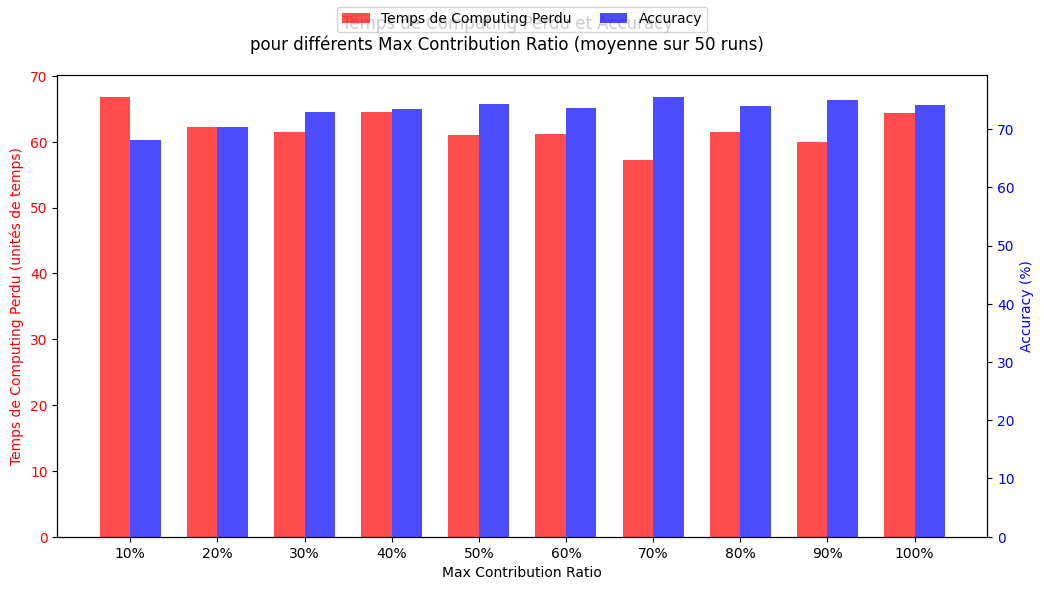

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# Fusionne les intervalles qui se chevauchent ou sont adjacents.

def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

def generate_dynamic_availability(total_time_steps, worker_id, max_periods=5, min_processing_time=2):
    mean = total_time_steps / 2 + random.randint(-total_time_steps // 4, total_time_steps // 4)
    std_dev = total_time_steps / 6
    availability_periods = []
    num_periods = random.randint(1, max_periods)
    for _ in range(num_periods):
        start_time = int(np.clip(np.random.normal(mean, std_dev), 0, total_time_steps - min_processing_time))
        duration = max(min_processing_time, int(np.abs(np.random.normal(3, 2))))
        end_time = min(start_time + duration, total_time_steps)
        if end_time - start_time >= min_processing_time:
            availability_periods.append((start_time, end_time))
    return merge_intervals(availability_periods)

# ------------------------------------------------------------------------------
# Définition du modèle de réseau de neurones
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de mini-batches avec SubsetRandomSampler
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Classe Worker : gère le calcul local des gradients
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_id = None
    def is_available(self, current_time):
        for start_time, end_time in self.availability_periods:
            if start_time <= current_time < end_time:
                if self.finish_time is None or current_time >= self.finish_time:
                    return (current_time + self.processing_time) <= end_time
        return False
    def start_computation(self, current_time, batch_id, data, targets):
        if self.current_batch_id is None or self.current_batch_id != batch_id:
            self.current_batch_id = batch_id
            self.finish_time = current_time + self.processing_time
            # Pour la simulation expérimentale, on ne fait pas d'affichage
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_id
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

# ------------------------------------------------------------------------------
# Serveur central : gère l'application des gradients
class Server:
    def __init__(self, dataset, batch_size=64, lr=0.001, max_contribution_ratio=0.5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleNN().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.current_batch = None
        self.current_batch_id = 0
        self.model_updated = True
        self.worker_contributions = {}
        self.wasted_gradients = {}       # On accumule ici le temps perdu par worker
        self.batch_send_times = {}       # Temps d'envoi de chaque batch
        self.total_wasted_time = 0
        self.max_contribution_ratio = max_contribution_ratio
    def update_global_model(self, worker_gradients, batch_id, worker_id, current_time):
        # Calcul du ratio de contribution (si applicable)
        total_contrib = sum(self.worker_contributions.values()) if self.worker_contributions else 0
        if total_contrib > 0:
            worker_ratio = self.worker_contributions.get(worker_id, 0) / total_contrib
            if worker_ratio >= self.max_contribution_ratio:
                send_time = self.batch_send_times.get(batch_id, current_time)
                wasted = current_time - send_time
                print(f"Worker {worker_id} a dépassé le seuil ({worker_ratio:.2f}). Gradient ignoré. Temps perdu: {wasted}")
                self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
                self.total_wasted_time += wasted
                return

        if worker_gradients is None or batch_id != self.current_batch_id:
            send_time = self.batch_send_times.get(batch_id, current_time)
            wasted = current_time - send_time
            print(f"Ignoré: Batch {batch_id} déjà traité pour Worker {worker_id}. Temps perdu: {wasted}")
            self.wasted_gradients[worker_id] = self.wasted_gradients.get(worker_id, 0) + wasted
            self.total_wasted_time += wasted
            return

        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = worker_gradients[name]
        self.optimizer.step()
        print(f"Modèle mis à jour avec Batch {batch_id} grâce à Worker {worker_id}.")
        self.worker_contributions[worker_id] = self.worker_contributions.get(worker_id, 0) + 1
        self.model_updated = True

    def compute_wasted_computing_time(self):
        return self.total_wasted_time

    def print_worker_statistics(self):
        print("\nRésumé des contributions utiles des workers :")
        sorted_contrib = sorted(self.worker_contributions.items(), key=lambda x: x[1], reverse=True)
        for worker_id, count in sorted_contrib:
            print(f"Worker {worker_id} a contribué {count} fois.")
        print("\nRésumé des wasted computing (temps perdu) :")
        sorted_wasted = sorted(self.wasted_gradients.items(), key=lambda x: x[1], reverse=True)
        for worker_id, wasted_time in sorted_wasted:
            print(f"Worker {worker_id} a perdu {wasted_time} unités de temps.")
        wasted_time_total = self.compute_wasted_computing_time()
        print(f"\nTemps total de computing perdu : {wasted_time_total} unités de temps.")

    def get_batch_for_worker(self, current_time):
        if self.model_updated:
            self.current_batch = self.batch_manager.get_next_batch()
            self.current_batch_id += 1
            self.batch_send_times[self.current_batch_id] = current_time
            self.model_updated = False
        return self.current_batch, self.current_batch_id

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        return 100 * correct / total

    def plot_wasted_computing(self):
        if not self.wasted_gradients:
            print("Aucun computing perdu à afficher.")
            return
        
        worker_ids = list(self.wasted_gradients.keys())
        wasted_times = list(self.wasted_gradients.values())
        plt.figure(figsize=(10, 6))
        plt.bar(worker_ids, wasted_times, color='red', alpha=0.7)
        plt.xlabel("ID du Worker")
        plt.ylabel("Unités de Temps de Computing Perdues")
        plt.title("Histogramme des Computing Perdus par Worker")
        plt.xticks(worker_ids)
        plt.yticks(np.arange(0, max(wasted_times)+1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# ------------------------------------------------------------------------------
# Simulation d'apprentissage fédéré (mode expérimental, sans affichage de plots intermédiaires)
class DiscreteEventSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=20):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.worker_computing = []
    def run(self, verbose=False):
        if verbose:
            print("Démarrage de la simulation...")
        while self.global_time < self.total_time_steps:
            if verbose:
                print(f"Temps {self.global_time}")
            # Fin des calculs terminés
            newly_finished_workers = [worker for worker in self.worker_computing if worker.has_finished(self.global_time)]
            for worker in newly_finished_workers:
                self.worker_computing.remove(worker)
                batch, _ = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                gradients, batch_id = worker.compute_gradient(data, targets)
                self.server.update_global_model(gradients, batch_id, worker.worker_id, self.global_time)
            # Lancement des calculs pour les workers disponibles
            available_workers = [worker for worker in self.workers if worker.is_available(self.global_time) and worker not in self.worker_computing]
            for worker in available_workers:
                batch, batch_id = self.server.get_batch_for_worker(self.global_time)
                data, targets = batch
                worker.start_computation(self.global_time, batch_id, data, targets)
                self.worker_computing.append(worker)
            self.global_time += 1
        return self.server.compute_wasted_computing_time(), self.server.evaluate(self.test_loader)

# ------------------------------------------------------------------------------
# Fonction pour exécuter plusieurs runs d'expérience pour un max_contribution_ratio donné
def run_experiment(max_ratio, num_runs=5, total_time_steps=51):
    wasted_list = []
    accuracy_list = []
    
    # Chargement des données
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for run in range(num_runs):
        # Réinitialisation du serveur avec le ratio spécifié
        server = Server(train_dataset, max_contribution_ratio=max_ratio)
        workers = []
        for i in range(1, 11):
            processing_time = random.randint(2, 4)
            availability = generate_normal_availability(50, mean=random.randint(10, 40), std_dev=6, 
                                                        max_periods=5, min_processing_time=processing_time)
            workers.append(Worker(server.model, server.device, i, availability, processing_time))
        # Enregistrer le processing time de chaque worker dans le serveur
        for worker in workers:
            # On utilise worker.worker_id et worker.processing_time
            server.worker_contributions.setdefault(worker.worker_id, 0)  # Initialisation
            # Ici, on ne fait pas d'enregistrement explicite car le serveur infère le temps via batch_send_times
        
        simulator = DiscreteEventSimulator(server, workers, test_loader, total_time_steps=total_time_steps)
        wasted, acc = simulator.run(verbose=False)
        wasted_list.append(wasted)
        accuracy_list.append(acc)
    
    return np.mean(wasted_list), np.mean(accuracy_list)

# ------------------------------------------------------------------------------
# Expérience : tester différents max_contribution_ratio de 10% à 100% (0.1 à 1.0)
ratios = np.arange(0.1, 1.01, 0.1)
avg_wasted = []
avg_accuracy = []
num_runs = 50

for ratio in ratios:
    wasted, acc = run_experiment(max_ratio=ratio, num_runs=num_runs, total_time_steps=51)
    avg_wasted.append(wasted)
    avg_accuracy.append(acc)
    print(f"Max Contribution Ratio: {ratio:.1f} | Temps moyen perdu: {wasted:.2f} | Accuracy moyenne: {acc:.2f}%")

# ------------------------------------------------------------------------------
# Plot des résultats : double histogramme (groupé)
x = np.arange(len(ratios))  # positions sur l'axe x
width = 0.35  # largeur des barres

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barres pour le temps de computing perdu
bars1 = ax1.bar(x - width/2, avg_wasted, width, label='Temps de Computing Perdu', color='red', alpha=0.7)
ax1.set_ylabel("Temps de Computing Perdu (unités de temps)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks(x)
ax1.set_xticklabels([f"{int(r*100)}%" for r in ratios])
ax1.set_xlabel("Max Contribution Ratio")

# Création d'un second axe pour l'accuracy
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_accuracy, width, label='Accuracy', color='blue', alpha=0.7)
ax2.set_ylabel("Accuracy (%)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Temps de Computing Perdu et Accuracy\npour différents Max Contribution Ratio (moyenne sur 50 runs)")
fig.legend(loc="upper center", ncol=2)
plt.show()
